In [1]:
# model.py
import torch
from torch import nn

def conv3x3(i, o): 
    return nn.Conv2d(i, o, 3, padding=1)

class DoubleConv(nn.Module):
    """传统UNet的双卷积块：Conv-ReLU-Conv-ReLU"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """下采样模块：MaxPool + DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """上采样模块：ConvTranspose + DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, 2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # 处理特征图尺寸不匹配的情况
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                                    diffY // 2, diffY - diffY // 2])
        # 跳跃连接
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet_4ch(nn.Module):
    """传统UNet结构，支持4通道输入"""
    def __init__(self, n_channels=4, n_classes=1):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        # 编码器
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        
        # 解码器
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        
        # 输出层
        self.outc = nn.Conv2d(64, n_classes, 1)
    
    def forward(self, x):
        # 编码路径
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # 解码路径
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        # 输出
        logits = self.outc(x)
        return logits

# 如果需要预训练权重初始化的版本
class UNet_4ch_Pretrained(nn.Module):
    """传统UNet结构，支持从3通道预训练权重初始化第4通道"""
    def __init__(self, n_channels=4, n_classes=1, pretrained_3ch_weights=None):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        # 编码器
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        
        # 解码器
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        
        # 输出层
        self.outc = nn.Conv2d(64, n_classes, 1)
        
        # 如果提供了3通道预训练权重，初始化第4通道
        if pretrained_3ch_weights is not None:
            self._init_4th_channel(pretrained_3ch_weights)
    
    def _init_4th_channel(self, pretrained_weights):
        """从3通道预训练权重初始化第4通道"""
        # 获取第一个卷积层的权重
        first_conv = self.inc.double_conv[0]
        if hasattr(pretrained_weights, 'inc.double_conv.0.weight'):
            pretrained_conv_weight = pretrained_weights['inc.double_conv.0.weight']
            pretrained_conv_bias = pretrained_weights['inc.double_conv.0.bias']
            
            with torch.no_grad():
                # 复制RGB权重
                first_conv.weight[:, :3] = pretrained_conv_weight
                # 第4通道初始化为RGB权重的均值
                first_conv.weight[:, 3:4] = pretrained_conv_weight.mean(1, keepdim=True)
                first_conv.bias = pretrained_conv_bias
    
    def forward(self, x):
        # 编码路径
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # 解码路径
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        # 输出
        logits = self.outc(x)
        return logits

In [5]:
# train_unet4ch.py
import os, csv, random, argparse
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import torch, torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
#from model import UNet_4ch                 # ★★ 改成传统UNet 4ch 版本

# ---------------- Dataset ----------------
class AerialPatchDataset4C(Dataset):
    """
    root/
     ├─ images/        austin1.tif ...
     ├─ depth_images/  austin1_depth.png / tif / jpg ...
     └─ gt/            austin1.tif (遮罩，與 images 同名)
    """
    COMMON_EXTS = [".png", ".jpg", ".jpeg", ".tif", ".tiff"]

    def __init__(self, root, crop=256):
        self.crop      = crop
        self.img_dir   = os.path.join(root, "images")
        self.depth_dir = os.path.join(root, "depth_images")
        self.mask_dir  = os.path.join(root, "gt")

        self.names     = sorted(os.listdir(self.img_dir))           # ex: austin1.tif
        self.depth_map = self._build_depth_map()                    # ★★ 建對應表

        self.mean = torch.tensor([0.485,0.456,0.406,0.5]).view(4,1,1)
        self.std  = torch.tensor([0.229,0.224,0.225,0.5]).view(4,1,1)

    # ----------  新增：掃描 depth_images ----------
    def _build_depth_map(self):
        depth_files = os.listdir(self.depth_dir)
        depth_dict  = {}
        for f in depth_files:
            stem, ext = os.path.splitext(f)
            if stem.endswith("_depth"):
                base = stem[:-6]                    # 去掉 "_depth"
                depth_dict[base] = f
        return depth_dict                           # {austin1: austin1_depth.png}

    def __len__(self): return len(self.names)

    def _random_crop(self, img, depth, msk):
        h, w = img.shape[:2]; ch = cw = self.crop
        top  = random.randint(0, h - ch); left = random.randint(0, w - cw)
        return (arr[top:top+ch, left:left+cw] for arr in (img, depth, msk))

    def __getitem__(self, idx):
        name = self.names[idx]                      # austin1.tif
        stem, ext = os.path.splitext(name)          # austin1, .tif
        try:
            # --- 找對應的深度圖檔名 ---
            if stem in self.depth_map:
                depth_fname = self.depth_map[stem]
            else:
                # 保險：按副檔名猜測
                depth_fname = None
                for ex in [ext] + self.COMMON_EXTS:
                    cand = f"{stem}_depth{ex}"
                    if os.path.exists(os.path.join(self.depth_dir, cand)):
                        depth_fname = cand; break
                if depth_fname is None:
                    raise FileNotFoundError(f"找不到 {stem}_depth.*")

            # --- 讀檔 ---
            rgb   = Image.open(os.path.join(self.img_dir,   name)).convert("RGB")
            depth = Image.open(os.path.join(self.depth_dir, depth_fname)).convert("L")
            msk   = Image.open(os.path.join(self.mask_dir,  name)).convert("L")

            rgb   = np.asarray(rgb)
            depth = np.asarray(depth)[..., None]              # H×W×1
            msk   = (np.asarray(msk) // 255).astype(np.uint8)

            rgb, depth, msk = self._random_crop(rgb, depth, msk)

            # --- to tensor ---
            rgb   = torch.from_numpy(rgb).permute(2,0,1).float() / 255.0
            depth = torch.from_numpy(depth).permute(2,0,1).float() / 255.0
            img4  = torch.cat([rgb, depth], 0)                # 4×H×W
            img4  = (img4 - self.mean) / self.std
            msk   = torch.from_numpy(msk).float().unsqueeze(0)
            return img4, msk

        except Exception as e:
            print(f"❌ [錯誤] {name}: {e}")
            return (torch.zeros(4, self.crop, self.crop),
                    torch.zeros(1, self.crop, self.crop))

# ---------------- Metric -----------------
def dice_coef(pred, target, eps=1e-7):
    pred = (torch.sigmoid(pred) > 0.5).float()
    inter = (pred * target).sum((1,2,3))
    union = pred.sum((1,2,3)) + target.sum((1,2,3))
    return ((2*inter+eps)/(union+eps)).mean()

# ---------------- Train ------------------
def main(args):
    torch.multiprocessing.set_start_method('spawn', force=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("🚀 Device:", device)

    root = r"E:\論文\空拍地圖語意分割\Depth4UNet\AerialImageDataset\train"
    if not os.path.exists(root):
        print(f"❌ 找不到資料目錄 {root}"); return

    data = AerialPatchDataset4C(root, crop=args.crop)
    print(f"📊 共 {len(data)} 張影像")
    v = int(0.1*len(data))
    train_ds, val_ds = torch.utils.data.random_split(data, [len(data)-v, v])

    def loader(ds, shf): return DataLoader(
        ds, batch_size=args.bs, shuffle=shf,
        num_workers=0, pin_memory=False, persistent_workers=False)

    train_ld, val_ld = loader(train_ds, True), loader(val_ds, False)

    # ★★ 改成传统UNet，支持4通道输入，1通道输出
    model = UNet_4ch(n_channels=4, n_classes=1).to(device)
    crit  = nn.BCEWithLogitsLoss()
    opt   = torch.optim.Adam(model.parameters(), lr=args.lr)
    scaler= torch.amp.GradScaler(device.type)

    best = 0; os.makedirs("checkpoints", exist_ok=True)
    with open("metrics.csv","w",newline="") as f:
        csv.writer(f).writerow(["epoch","train_loss","val_loss","dice"])

    for ep in range(1, args.epochs+1):
        # ---- train ----
        model.train(); tr_loss=0; n_tr=0
        for img,msk in tqdm(train_ld, desc=f"Ep{ep}/{args.epochs} train"):
            img,msk = img.to(device), msk.to(device)
            with torch.amp.autocast(device.type):
                pred = model(img); loss = crit(pred, msk)
            opt.zero_grad(); scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
            tr_loss += loss.item(); n_tr += 1

        # ---- val ----
        model.eval(); vl_loss=0; dices=[]; n_v=0
        with torch.no_grad():
            for img,msk in tqdm(val_ld, desc=f"Ep{ep}/{args.epochs} val"):
                img,msk = img.to(device), msk.to(device)
                with torch.amp.autocast(device.type):
                    pred = model(img); loss = crit(pred, msk)
                vl_loss += loss.item(); dices.append(dice_coef(pred, msk).item()); n_v += 1

        tr_loss /= max(n_tr,1); vl_loss /= max(n_v,1); dice = np.mean(dices) if dices else 0
        print(f"📝 Ep{ep} train={tr_loss:.4f} val={vl_loss:.4f} dice={dice:.4f}")
        with open("metrics.csv","a",newline="") as f:
            csv.writer(f).writerow([ep,tr_loss,vl_loss,dice])

        if dice > best:
            best = dice
            torch.save(model.state_dict(), "checkpoints/best_traditional_unet4ch.pth")
            print(f"  👑  Saved best model (dice {best:.4f})")

# ---------------- Run --------------------
if __name__ == "__main__":
    args = argparse.Namespace(epochs=100, bs=4, lr=1e-4, crop=256)
    main(args)

🚀 Device: cuda
📊 共 180 張影像


Ep1/100 train:   0%|          | 0/41 [00:00<?, ?it/s]C:\Users\op237\AppData\Local\Temp\ipykernel_18860\3777291326.py:80: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:212.)
  rgb   = torch.from_numpy(rgb).permute(2,0,1).float() / 255.0
Ep1/100 val: 100%|██████████| 5/5 [00:23<00:00,  4.69s/it]


📝 Ep1 train=0.5826 val=0.4677 dice=0.3500
  👑  Saved best model (dice 0.3500)


Ep2/100 val: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


📝 Ep2 train=0.4074 val=0.4277 dice=0.3000


Ep3/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep3 train=0.4255 val=0.4200 dice=0.3000


Ep4/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep4 train=0.3286 val=0.3602 dice=0.2500


Ep5/100 val: 100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


📝 Ep5 train=0.3542 val=0.3549 dice=0.3068


Ep6/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep6 train=0.3698 val=0.4520 dice=0.3594
  👑  Saved best model (dice 0.3594)


Ep7/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


📝 Ep7 train=0.3369 val=0.3788 dice=0.2753


Ep8/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep8 train=0.3122 val=0.3592 dice=0.1898


Ep9/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep9 train=0.3355 val=0.4302 dice=0.2048


Ep10/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep10 train=0.3377 val=0.3370 dice=0.4865
  👑  Saved best model (dice 0.4865)


Ep11/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep11 train=0.3505 val=0.3045 dice=0.4090


Ep12/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


📝 Ep12 train=0.3432 val=0.4206 dice=0.4482


Ep13/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep13 train=0.3255 val=0.3245 dice=0.4505


Ep14/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


📝 Ep14 train=0.2941 val=0.2471 dice=0.6225
  👑  Saved best model (dice 0.6225)


Ep15/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


📝 Ep15 train=0.3196 val=0.2929 dice=0.3074


Ep16/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


📝 Ep16 train=0.3246 val=0.3987 dice=0.4751


Ep17/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


📝 Ep17 train=0.2975 val=0.3097 dice=0.5661


Ep18/100 val: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]


📝 Ep18 train=0.3131 val=0.3007 dice=0.4994


Ep19/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


📝 Ep19 train=0.3106 val=0.2872 dice=0.5088


Ep20/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


📝 Ep20 train=0.2906 val=0.2963 dice=0.5460


Ep21/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


📝 Ep21 train=0.2747 val=0.3969 dice=0.4431


Ep22/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


📝 Ep22 train=0.3092 val=0.3273 dice=0.5919


Ep23/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep23 train=0.3272 val=0.2919 dice=0.6562
  👑  Saved best model (dice 0.6562)


Ep24/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep24 train=0.2844 val=0.2915 dice=0.5061


Ep25/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


📝 Ep25 train=0.3223 val=0.2741 dice=0.7139
  👑  Saved best model (dice 0.7139)


Ep26/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


📝 Ep26 train=0.2908 val=0.2938 dice=0.5245


Ep27/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


📝 Ep27 train=0.2964 val=0.2681 dice=0.5157


Ep28/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


📝 Ep28 train=0.3156 val=0.3508 dice=0.5287


Ep29/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


📝 Ep29 train=0.2844 val=0.2660 dice=0.6170


Ep30/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


📝 Ep30 train=0.2883 val=0.3406 dice=0.6071


Ep31/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep31 train=0.2578 val=0.2905 dice=0.5008


Ep32/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep32 train=0.2553 val=0.2623 dice=0.6037


Ep33/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


📝 Ep33 train=0.2887 val=0.2540 dice=0.4501


Ep34/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep34 train=0.3108 val=0.3029 dice=0.5292


Ep35/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep35 train=0.2958 val=0.3631 dice=0.5983


Ep36/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep36 train=0.2932 val=0.2951 dice=0.6590


Ep37/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep37 train=0.2429 val=0.3422 dice=0.6135


Ep38/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


📝 Ep38 train=0.3004 val=0.3381 dice=0.6118


Ep39/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


📝 Ep39 train=0.2507 val=0.2550 dice=0.4795


Ep40/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep40 train=0.2765 val=0.4320 dice=0.5018


Ep41/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep41 train=0.2698 val=0.2251 dice=0.5945


Ep42/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep42 train=0.2794 val=0.2823 dice=0.6964


Ep43/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


📝 Ep43 train=0.2577 val=0.3910 dice=0.5648


Ep44/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


📝 Ep44 train=0.2887 val=0.3385 dice=0.5409


Ep45/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


📝 Ep45 train=0.2803 val=0.2785 dice=0.6141


Ep46/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


📝 Ep46 train=0.2548 val=0.2626 dice=0.6778


Ep47/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


📝 Ep47 train=0.2883 val=0.3079 dice=0.6634


Ep48/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


📝 Ep48 train=0.2994 val=0.2458 dice=0.5338


Ep49/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


📝 Ep49 train=0.3015 val=0.2574 dice=0.5791


Ep50/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


📝 Ep50 train=0.2503 val=0.3237 dice=0.6691


Ep51/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep51 train=0.2433 val=0.3316 dice=0.5877


Ep52/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep52 train=0.2617 val=0.2409 dice=0.5670


Ep53/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


📝 Ep53 train=0.2374 val=0.2496 dice=0.6775


Ep54/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


📝 Ep54 train=0.2688 val=0.2217 dice=0.6634


Ep55/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep55 train=0.2660 val=0.2416 dice=0.6366


Ep56/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


📝 Ep56 train=0.2172 val=0.3086 dice=0.4142


Ep57/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep57 train=0.2343 val=0.3146 dice=0.7613
  👑  Saved best model (dice 0.7613)


Ep58/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


📝 Ep58 train=0.2688 val=0.2251 dice=0.6285


Ep59/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep59 train=0.2512 val=0.2990 dice=0.5745


Ep60/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep60 train=0.2788 val=0.2475 dice=0.6809


Ep61/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


📝 Ep61 train=0.2599 val=0.2001 dice=0.5861


Ep62/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


📝 Ep62 train=0.2678 val=0.2521 dice=0.6310


Ep63/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep63 train=0.2447 val=0.2476 dice=0.6086


Ep64/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


📝 Ep64 train=0.2566 val=0.2912 dice=0.6423


Ep65/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


📝 Ep65 train=0.2106 val=0.2258 dice=0.7016


Ep66/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep66 train=0.2230 val=0.2636 dice=0.7087


Ep67/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep67 train=0.2701 val=0.2265 dice=0.5632


Ep68/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep68 train=0.2458 val=0.2401 dice=0.5952


Ep69/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep69 train=0.2495 val=0.2347 dice=0.5918


Ep70/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep70 train=0.2386 val=0.2591 dice=0.4725


Ep71/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep71 train=0.2433 val=0.2776 dice=0.5493


Ep72/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


📝 Ep72 train=0.2557 val=0.3354 dice=0.4775


Ep73/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


📝 Ep73 train=0.2347 val=0.2018 dice=0.7133


Ep74/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep74 train=0.2212 val=0.2869 dice=0.7047


Ep75/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep75 train=0.2499 val=0.2968 dice=0.4598


Ep76/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


📝 Ep76 train=0.2242 val=0.2120 dice=0.6684


Ep77/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


📝 Ep77 train=0.2394 val=0.2102 dice=0.5695


Ep78/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep78 train=0.2329 val=0.2124 dice=0.7168


Ep79/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep79 train=0.2412 val=0.2726 dice=0.6636


Ep80/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep80 train=0.2304 val=0.2111 dice=0.6525


Ep81/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


📝 Ep81 train=0.2522 val=0.3102 dice=0.7009


Ep82/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep82 train=0.2290 val=0.2771 dice=0.6278


Ep83/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep83 train=0.2276 val=0.2370 dice=0.7328


Ep84/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep84 train=0.2165 val=0.2752 dice=0.5935


Ep85/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


📝 Ep85 train=0.2278 val=0.2496 dice=0.7309


Ep86/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


📝 Ep86 train=0.2319 val=0.2760 dice=0.6665


Ep87/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep87 train=0.2223 val=0.2667 dice=0.6241


Ep88/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep88 train=0.2600 val=0.2162 dice=0.6327


Ep89/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep89 train=0.2514 val=0.2449 dice=0.6114


Ep90/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep90 train=0.2277 val=0.1892 dice=0.5619


Ep91/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep91 train=0.2215 val=0.2047 dice=0.6387


Ep92/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep92 train=0.2262 val=0.2567 dice=0.6429


Ep93/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep93 train=0.2669 val=0.2091 dice=0.6842


Ep94/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep94 train=0.2415 val=0.2430 dice=0.7403


Ep95/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep95 train=0.2817 val=0.3078 dice=0.5498


Ep96/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep96 train=0.2454 val=0.2284 dice=0.6581


Ep97/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep97 train=0.2541 val=0.3350 dice=0.4312


Ep98/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep98 train=0.2623 val=0.2525 dice=0.7400


Ep99/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep99 train=0.2407 val=0.2990 dice=0.6431


Ep100/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]

📝 Ep100 train=0.2156 val=0.2971 dice=0.6069


C:\Users\op237\AppData\Local\Temp\ipykernel_18860\137112966.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(CKPT_PATH, map_location=dev

✅ 所有評估圖與 CSV 已輸出至 eval_figs


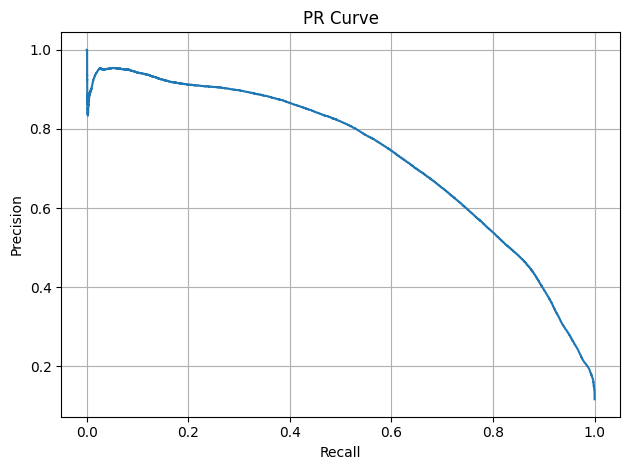

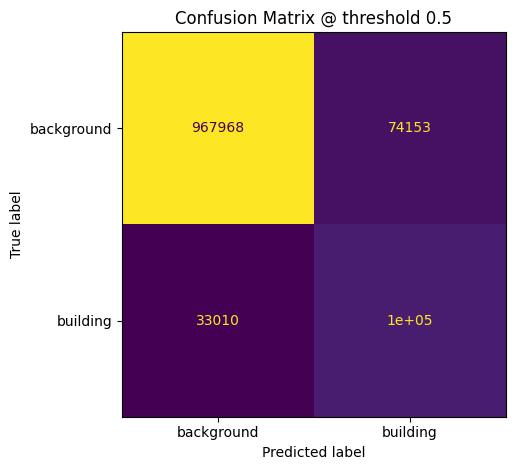

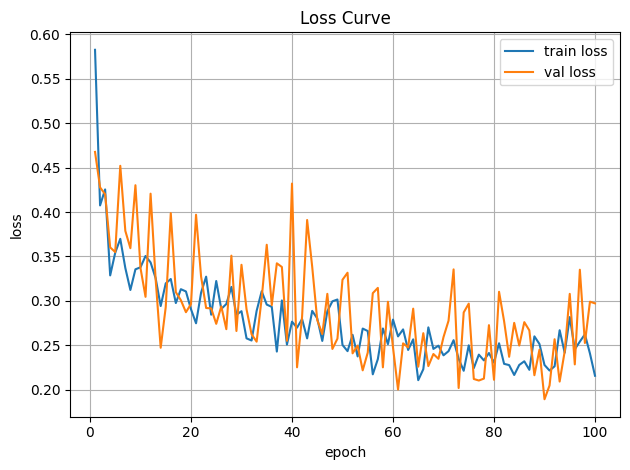

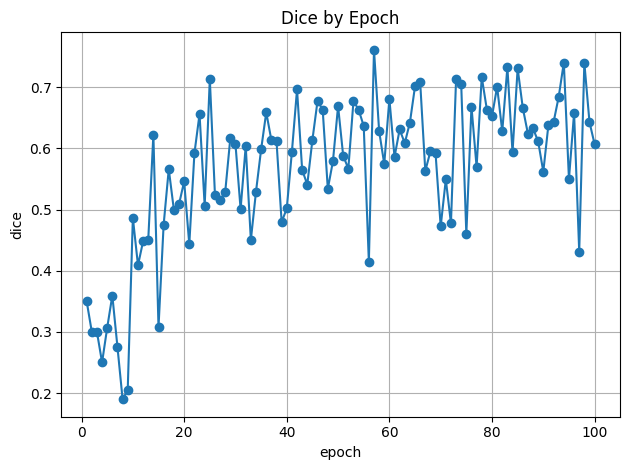

In [ ]:
# ------------------------------------------------------------
# 0. 環境與資料集設定
# ------------------------------------------------------------
import os, csv, numpy as np, torch, torchvision, matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

# ========= 路徑參數（照自己的實際路徑調） =========
ROOT_DIR     = r"E:\論文\空拍地圖語意分割\Depth4UNet\AerialImageDataset\train"
CKPT_PATH    = "checkpoints/best_traditional_unet4ch.pth"
METRICS_CSV  = r"E:\論文\空拍地圖語意分割\Depth4UNet\train_history copy\GELU_metrics.csv"          # 還是沿用原訓練 csv 畫 loss / dice
OUT_DIR      = "eval_figs"            # 所有圖與 csv 會丟在這
os.makedirs(OUT_DIR, exist_ok=True)

# ========= 補：把 val set 重建出來 =========
#from train_unet4ch import AerialPatchDataset4C, UNet_4ch   # ← 若.py 名稱不同，自己改
full_ds  = AerialPatchDataset4C(ROOT_DIR, crop=256)
v        = int(0.1 * len(full_ds))
_, val_ds = torch.utils.data.random_split(full_ds, [len(full_ds)-v, v], generator=torch.Generator().manual_seed(0))
val_ld   = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=0)

# ------------------------------------------------------------
# 1. 載入模型並跑驗證集，收集 y_true / y_score
# ------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = UNet_4ch(n_channels=4, n_classes=1).to(device)
model.load_state_dict(torch.load(CKPT_PATH, map_location=device))
model.eval()

all_gt, all_prob = [], []
with torch.no_grad():
    for img, msk in val_ld:
        img = img.to(device)
        logits = model(img)
        prob   = torch.sigmoid(logits).cpu()          # 機率 [0,1]
        all_gt.append(msk);  all_prob.append(prob)

y_true  = torch.cat(all_gt,   0).numpy().ravel()
y_score = torch.cat(all_prob, 0).numpy().ravel()

# ------------------------------------------------------------
# 2. Precision-Recall、Confusion Matrix、圖 & CSV
# ------------------------------------------------------------
precision, recall, thresholds = precision_recall_curve(y_true, y_score)
thresholds = np.append(thresholds, 1.0)               # 跟 recall/precision 對齊

# -- PR 曲線 --
plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curve")
plt.grid(); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pr_curve.png"), dpi=150)

# 存 PR 數據
with open(os.path.join(OUT_DIR, "pr_curve.csv"), "w", newline="") as f:
    csv.writer(f).writerow(["threshold","recall","precision"])
    csv.writer(f).writerows(zip(thresholds, recall, precision))

# -- Confusion Matrix（threshold=0.5，可自行挑最佳 F1 門檻） --
y_pred = (y_score >= 0.5).astype(int)
cm     = confusion_matrix(y_true, y_pred, labels=[0,1])

fig, ax = plt.subplots()
ConfusionMatrixDisplay(cm, display_labels=["background","building"]).plot(
    cmap=None, ax=ax, colorbar=False)
ax.set_title("Confusion Matrix @ threshold 0.5")
plt.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "conf_matrix.png"), dpi=150)

# ------------------------------------------------------------
# 3. 讀舊 metrics.csv 畫 Loss / Dice (跟之前流程相同)
# ------------------------------------------------------------
epochs, tr_loss, val_loss, dice = [], [], [], []
with open(METRICS_CSV, newline="") as f:
    for row in csv.DictReader(f):
        epochs.append(int(row["epoch"]))
        tr_loss.append(float(row["train_loss"]))
        val_loss.append(float(row["val_loss"]))
        dice.append(float(row["dice"]))

plt.figure()
plt.plot(epochs, tr_loss, label="train loss")
plt.plot(epochs, val_loss,  label="val loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Loss Curve")
plt.grid(); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "loss_curve.png"), dpi=150)

plt.figure()
plt.plot(epochs, dice, marker='o')
plt.xlabel("epoch"); plt.ylabel("dice"); plt.title("Dice by Epoch")
plt.grid(); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "dice_curve.png"), dpi=150)

print("✅ 所有評估圖與 CSV 已輸出至", OUT_DIR)


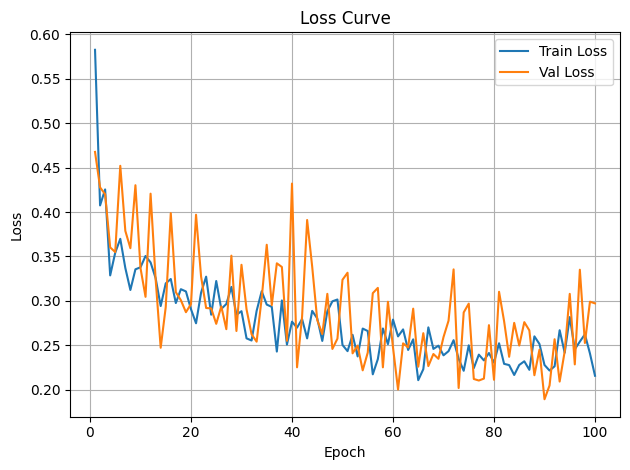

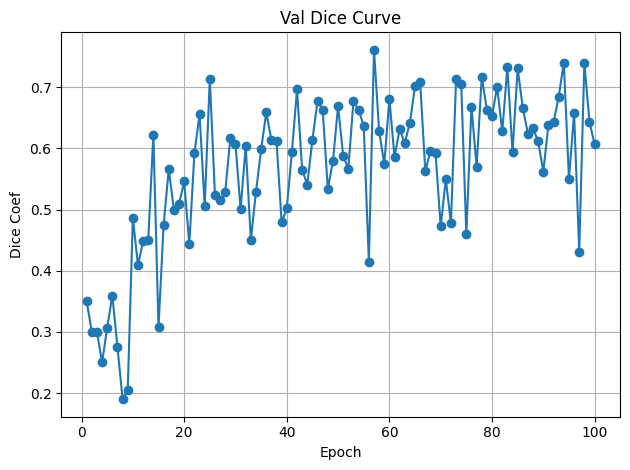

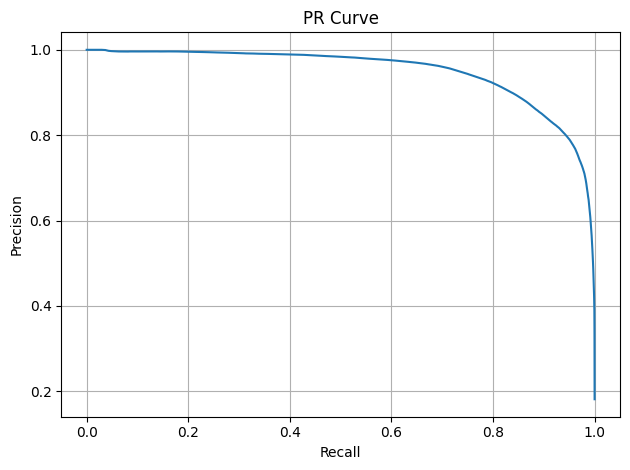

✅  圖片 loss_curve.png / dice_curve.png / pr_curve.png 以及資料 pr_curve.csv 已儲存完畢！


In [16]:
# 📦 需要的套件
import csv, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix
import pandas as pd

# ==============================================================
# 1. 載入 metrics.csv（Epoch 累積的 Loss & Dice）
# ==============================================================
epochs, tr_loss, val_loss, dice = [], [], [], []
with open(r"E:\論文\空拍地圖語意分割\Depth4UNet\train_history copy\Unet_metrics.csv") as f:
    reader = csv.DictReader(f)
    for r in reader:
        epochs.append(int(r["epoch"]))
        tr_loss.append(float(r["train_loss"]))
        val_loss.append(float(r["val_loss"]))
        dice.append(float(r["dice"]))

# --------------------------------------------------------------
# 2. 載入 val_pred.npz（y_true, y_score 由驗證階段存檔）
#    若還沒存檔，請在驗證迴圈加上：
#    ➜ np.savez("val_pred.npz", y_true=all_gt, y_score=all_prob)
# --------------------------------------------------------------
dat = np.load("val_pred.npz")
y_true, y_score = dat["y_true"], dat["y_score"]

precision, recall, thresholds = precision_recall_curve(y_true.ravel(), y_score.ravel())

# ==============================================================
# 3. 畫圖 & 存檔
# ==============================================================

# 3-1 Loss 曲線
plt.figure()
plt.plot(epochs, tr_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curve")
plt.grid(); plt.legend(); plt.tight_layout()
plt.savefig("loss_curve.png", dpi=150)

# 3-2 Dice 曲線
plt.figure()
plt.plot(epochs, dice, marker="o")
plt.xlabel("Epoch"); plt.ylabel("Dice Coef"); plt.title("Val Dice Curve")
plt.grid(); plt.tight_layout()
plt.savefig("dice_curve.png", dpi=150)

# 3-3 PR 曲線
plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curve")
plt.grid(); plt.tight_layout()
plt.savefig("pr_curve.png", dpi=150)

plt.show()

# ==============================================================
# 4. 另存 PR 曲線數據成 CSV
# ==============================================================
pr_df = pd.DataFrame({
    "threshold": list(thresholds) + [1.0],   # precision, recall 比 thresholds 多 1
    "precision": precision,
    "recall": recall
})
pr_df.to_csv("pr_curve.csv", index=False)
print("✅  圖片 loss_curve.png / dice_curve.png / pr_curve.png 以及資料 pr_curve.csv 已儲存完畢！")


🚀 Using device: cuda


C:\Users\op237\AppData\Local\Temp\ipykernel_18860\46951748.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(CKPT_PATH, map_location=DEVI

📥 Loading images …
📐 Image size: 5000×5000
🔍 Starting prediction…
🔄 Processing 81 windows…
  Progress: 10/81 (12.3 %)
  Progress: 20/81 (24.7 %)
  Progress: 30/81 (37.0 %)
  Progress: 40/81 (49.4 %)
  Progress: 50/81 (61.7 %)
  Progress: 60/81 (74.1 %)
  Progress: 70/81 (86.4 %)
  Progress: 80/81 (98.8 %)
  Progress: 81/81 (100.0 %)
✅ Saved blended result: E:\論文\空拍地圖語意分割\Depth4UNet\AerialImageDataset\test\images\bellingham1_RGBD_pred.png
✅ Saved mask: E:\論文\空拍地圖語意分割\Depth4UNet\AerialImageDataset\test\images\bellingham1_RGBD_mask.png
🎉 Prediction completed!


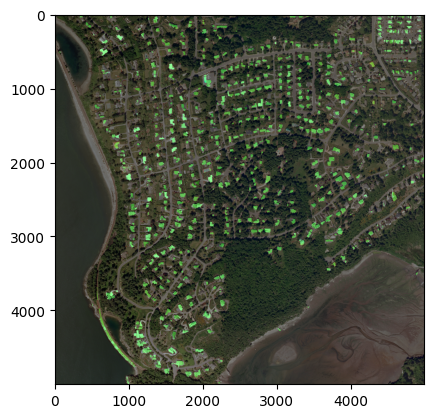

In [14]:
# ------------------ Demo Predict (RGB + Depth，滑窗版 1024×1024) ------------------
"""
此腳本示範如何對 **RGB 圖 + 單通道深度圖** 進行語意分割推論。
假設模型輸入為 4 通道（RGB→3 + Depth→1）。
"""
import os
from typing import Tuple

import numpy as np
from PIL import Image

import torch
import torch.nn.functional as F
import torchvision

# ------------------------------------------------------------
# ⚙️ 1. 手動設定
# ------------------------------------------------------------
RGB_PATH   = r"E:\論文\空拍地圖語意分割\Depth4UNet\AerialImageDataset\test\images\bellingham1.tif"
DEPTH_PATH = r"E:\論文\空拍地圖語意分割\Depth4UNet\depth\bellingham1_depth.png"
CKPT_PATH  = r"E:\論文\空拍地圖語意分割\Depth4UNet\checkpoints\best_traditional_unet4ch.pth"

WINDOW_SIZE = 1024  # 滑窗大小
STRIDE      = 512   # 滑窗步長（50 % 重疊）

# ------------------------------------------------------------
# ⚙️ 2. 運算裝置
# ------------------------------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🚀 Using device:", DEVICE)

# ------------------------------------------------------------
# ⚙️ 3. 載入模型（UNet11_4ch，RGBD → 1 類）
# ------------------------------------------------------------
#from model import UNet11_4ch             # ★ 修正：改回與訓練一致的類別

model = UNet_4ch().to(DEVICE).eval()   # ★ 修正：名稱同步
model.load_state_dict(torch.load(CKPT_PATH, map_location=DEVICE))

# ------------------------------------------------------------
# ⚙️ 4. 影像讀取
# ------------------------------------------------------------
print("📥 Loading images …")
rgb_img = Image.open(RGB_PATH).convert("RGB")            # (H,W,3)
raw_depth = Image.open(DEPTH_PATH)                       # 單通道或 16-bit

# 深度圖若非 8-bit，做一次全幅 min-max → 0–255
if raw_depth.mode != "L":
    d_np = np.array(raw_depth, dtype=np.float32)
    d_np = 255.0 * (d_np - d_np.min()) / max(d_np.ptp(), 1e-6)
    depth_img = Image.fromarray(d_np.astype(np.uint8))
else:
    depth_img = raw_depth

W, H = rgb_img.size
print(f"📐 Image size: {W}×{H}")

# ------------------------------------------------------------
# ⚙️ 5. 前處理
# ------------------------------------------------------------
_rgb_tf = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
])
_depth_tf = torchvision.transforms.ToTensor()            # 0-1 float32

def preprocess_patch(rgb: Image.Image, depth: Image.Image) -> torch.Tensor:
    t_rgb   = _rgb_tf(rgb)
    t_depth = _depth_tf(depth)            # (1,H,W)
    return torch.cat([t_rgb, t_depth], 0).unsqueeze(0).to(DEVICE)

# ------------------------------------------------------------
# ⚙️ 6. Pad-to-32
# ------------------------------------------------------------
def pad32(x: torch.Tensor) -> Tuple[torch.Tensor, int, int]:
    _, _, h, w = x.shape
    ph = (32 - h % 32) % 32
    pw = (32 - w % 32) % 32
    return F.pad(x, (0, pw, 0, ph)), ph, pw

# ------------------------------------------------------------
# ⚙️ 7. 小圖直接預測
# ------------------------------------------------------------
@torch.inference_mode()
def direct_predict(rgb_np: np.ndarray, depth_np: np.ndarray) -> np.ndarray:
    rgb_pil, depth_pil = Image.fromarray(rgb_np), Image.fromarray(depth_np)
    x, ph, pw = pad32(preprocess_patch(rgb_pil, depth_pil))
    logits = model(x)
    if ph or pw:
        logits = logits[..., : -ph or None, : -pw or None]
    return torch.sigmoid(logits)[0, 0].cpu().numpy()

# ------------------------------------------------------------
# ⚙️ 8. 滑窗預測
# ------------------------------------------------------------
@torch.inference_mode()
def sliding_window_predict(rgb_np: np.ndarray, depth_np: np.ndarray,
                           window: int, stride: int) -> np.ndarray:

    H, W, _ = rgb_np.shape
    if H <= window and W <= window:
        return direct_predict(rgb_np, depth_np)

    out_mask = np.zeros((H, W), np.float32)
    weight   = np.zeros((H, W), np.float32)

    y_pos = list(range(0, max(1, H - window + 1), stride))
    x_pos = list(range(0, max(1, W - window + 1), stride))
    if y_pos[-1] + window < H:
        y_pos.append(H - window)
    if x_pos[-1] + window < W:
        x_pos.append(W - window)

    total, idx = len(y_pos) * len(x_pos), 0
    print(f"🔄 Processing {total} windows…")
    for y in y_pos:
        for x in x_pos:
            idx += 1
            rgb_win   = rgb_np[y:y+window, x:x+window]
            depth_win = depth_np[y:y+window, x:x+window]

            # 邊界 pad
            pad_rgb   = np.zeros((window, window, 3), np.uint8)
            pad_depth = np.zeros((window, window),    np.uint8)
            pad_rgb[:rgb_win.shape[0], :rgb_win.shape[1]] = rgb_win
            pad_depth[:depth_win.shape[0], :depth_win.shape[1]] = depth_win

            x_pad, ph, pw = pad32(
                preprocess_patch(Image.fromarray(pad_rgb), Image.fromarray(pad_depth))
            )
            logits = model(x_pad)
            if ph or pw:
                logits = logits[..., : -ph or None, : -pw or None]
            prob = torch.sigmoid(logits)[0, 0].cpu().numpy()
            prob = prob[:rgb_win.shape[0], :rgb_win.shape[1]]

            out_mask[y:y+prob.shape[0], x:x+prob.shape[1]] += prob
            weight[y:y+prob.shape[0],  x:x+prob.shape[1]] += 1
            if idx % 10 == 0 or idx == total:
                print(f"  Progress: {idx}/{total} ({idx/total*100:.1f} %)")

    return np.divide(out_mask, weight, out=np.zeros_like(out_mask), where=weight != 0)

# ------------------------------------------------------------
# ⚙️ 9. 執行預測
# ------------------------------------------------------------
print("🔍 Starting prediction…")
prob_mask = sliding_window_predict(np.array(rgb_img),
                                   np.array(depth_img),
                                   WINDOW_SIZE, STRIDE)

# ------------------------------------------------------------
# ⚙️ 10. 後處理與儲存
# ------------------------------------------------------------
THRESH = 0.5
binary = (prob_mask > THRESH).astype(np.uint8) * 255

mask_rgb = np.zeros((*binary.shape, 3), np.uint8)
mask_rgb[..., 1] = binary  # 綠色

blend = Image.blend(rgb_img, Image.fromarray(mask_rgb), alpha=0.4)
plt.imshow(blend)
out_base = os.path.splitext(RGB_PATH)[0]
blend.save(out_base + "_RGBD_pred.png")
Image.fromarray(binary).save(out_base + "_RGBD_mask.png")

print("✅ Saved blended result:", out_base + "_RGBD_pred.png")
print("✅ Saved mask:", out_base + "_RGBD_mask.png")
print("🎉 Prediction completed!")
